#Initial Autoencoder Test with MNIST
Run each cell with <Shift + Enter>

In [2]:
# import all the libraries!
import os
import pdb
import time

# scientific packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import fastprogress # progress bar
from pathlib import Path # Path object

# machine learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

# for prebuilt CNNs
from fastai.vision import *

# Interactive Plots
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)


Import the MNIST dataset and throw them into DataLoaders

In [7]:
BATCH_SIZE = 200
trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# for visualisation
viz_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:01, 8577801.01it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130602.44it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2141962.40it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 48736.32it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Define the Variational Autoencoder encoder and decoder

Define the encoder and decoder class
This uses an initial convolution layer which lots of state of the art image recognition architectures use.

In [0]:
class VAE_encoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_encoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Conv2d(1,1,kernel_size=(2,2),stride=(2,2),padding=(1,1),bias=False),
                        nn.BatchNorm2d(num_features=1), nn.ReLU(inplace=True))#, nn.MaxPool2d(kernel_size=(2,2),stride=(1,1)))
        #self.fc1 = nn.Linear(784, 400)
        self.fc2m = nn.Linear(225, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(225, latent_variable_dim) # use for standard deviation

    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        #pdb.set_trace()
        x = input.view(-1, 1,28,28)
        x = self.encoder(x)
        #print(x.shape)
        x = x.view(x.size(0),-1) # 225 vector
        #print(x.shape)
        
        #torch.relu(self.fc1(x))
        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        #import pdb; pdb.set_trace()
        
        return z, m, log_s
    

In [0]:
class VAE_decoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_decoder, self).__init__()
        
        self.f1 = nn.Linear(latent_variable_dim,225)
        self.decoder = nn.Sequential(
                        #nn.Upsample(scale_factor=1,mode='bilinear',align_corners=False),
                        nn.BatchNorm2d(num_features=1),nn.ReLU(inplace=True),
                        nn.Upsample(size=(28, 28), mode='bilinear',align_corners=False))
        self.fc1 = nn.Linear(latent_variable_dim, 400)
        self.fc2 = nn.Linear(400, 784)
        
    def forward(self, z):
        #x = torch.relu(self.fc1(z))
        #x = torch.sigmoid(self.fc2(x))
        #pdb.set_trace()
        z = torch.relu(self.f1(z))
        x = z.view(z.size(0),1,15,15)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        
        return x
        

Cross entropy loss + KL divergence

In [0]:

def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image.view(-1,28*28), input_image.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return CE + KLD

Train the autoencoder for 5 epochs on GPU


tensor(107228.3047, device='cuda:0', grad_fn=<AddBackward0>) tensor(107323.3750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(106848.1953, device='cuda:0', grad_fn=<AddBackward0>) tensor(107030.6797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(106947.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(106888.0156, device='cuda:0', grad_fn=<AddBackward0>)
tensor(106920.0391, device='cuda:0', grad_fn=<AddBackward0>) tensor(106985.8125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(106977.9609, device='cuda:0', grad_fn=<AddBackward0>) tensor(106983.1953, device='cuda:0', grad_fn=<AddBackward0>)


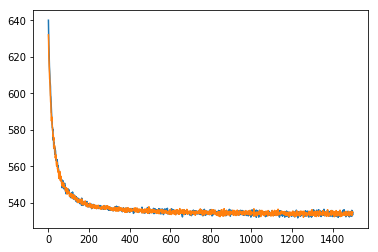

In [15]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
'''
'''
vae_encoder = VAE_encoder(10).to(device)
vae_decoder = VAE_decoder(10).to(device)

optimizer = optim.Adam(list(vae_encoder.parameters()) +list(vae_decoder.parameters()), lr = 0.003)
train_loss = []
val_loss = []
'''
'''
for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        optimizer.zero_grad()
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        larr = loss(images, recon_image, mu, s)
        
        larr.backward()
        train_loss.append(larr.item() / len(images))
        optimizer.step()
        
        i, data = next(iter(testloader))
        images = i
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        
        larr2 = loss(images, recon_image, mu, s)
        val_loss.append(larr2.item() / len(images))
        
    print(larr,larr2)
    
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

orange is training loss
blue is validation loss

##Visualisation of the latent space

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [0]:
def pretty_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        
        selected = x[colors == i, :2]
        xtext, ytext = np.median(selected, axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

Check the encoding features in 2D space

torch.Size([200, 10]) torch.Size([200])


(<Figure size 576x576 with 1 Axes>,
 [Text(3.028013, 10.734986, '0'),
  Text(-2.2714684, 2.004469, '1'),
  Text(-6.115884, 2.0320508, '2'),
  Text(7.20763, 3.3221304, '3'),
  Text(0.67607945, -7.7975693, '4'),
  Text(1.2007322, 1.2947096, '5'),
  Text(-8.112129, -3.9626298, '6'),
  Text(7.4037023, -5.8342414, '7'),
  Text(2.2601027, 1.449548, '8'),
  Text(5.23213, -6.4691753, '9')])

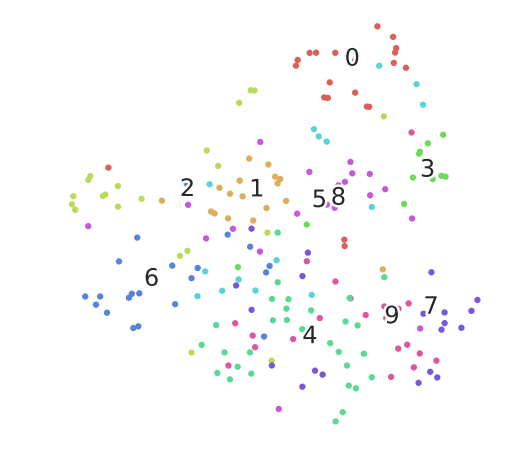

In [18]:
with torch.no_grad():
    for i, data in enumerate(viz_loader, 0):
        images, labels = data
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        print(mu.shape, labels.shape)
        pca = PCA(n_components=4)
        pca_result = pca.fit_transform(mu.cpu().numpy())
        fashion_tsne = TSNE().fit_transform(mu.cpu().numpy())
        
        break
pretty_scatter(fashion_tsne,labels.numpy())
#pretty_scatter(pca_result,labels.numpy())

Let's see some reconstructions

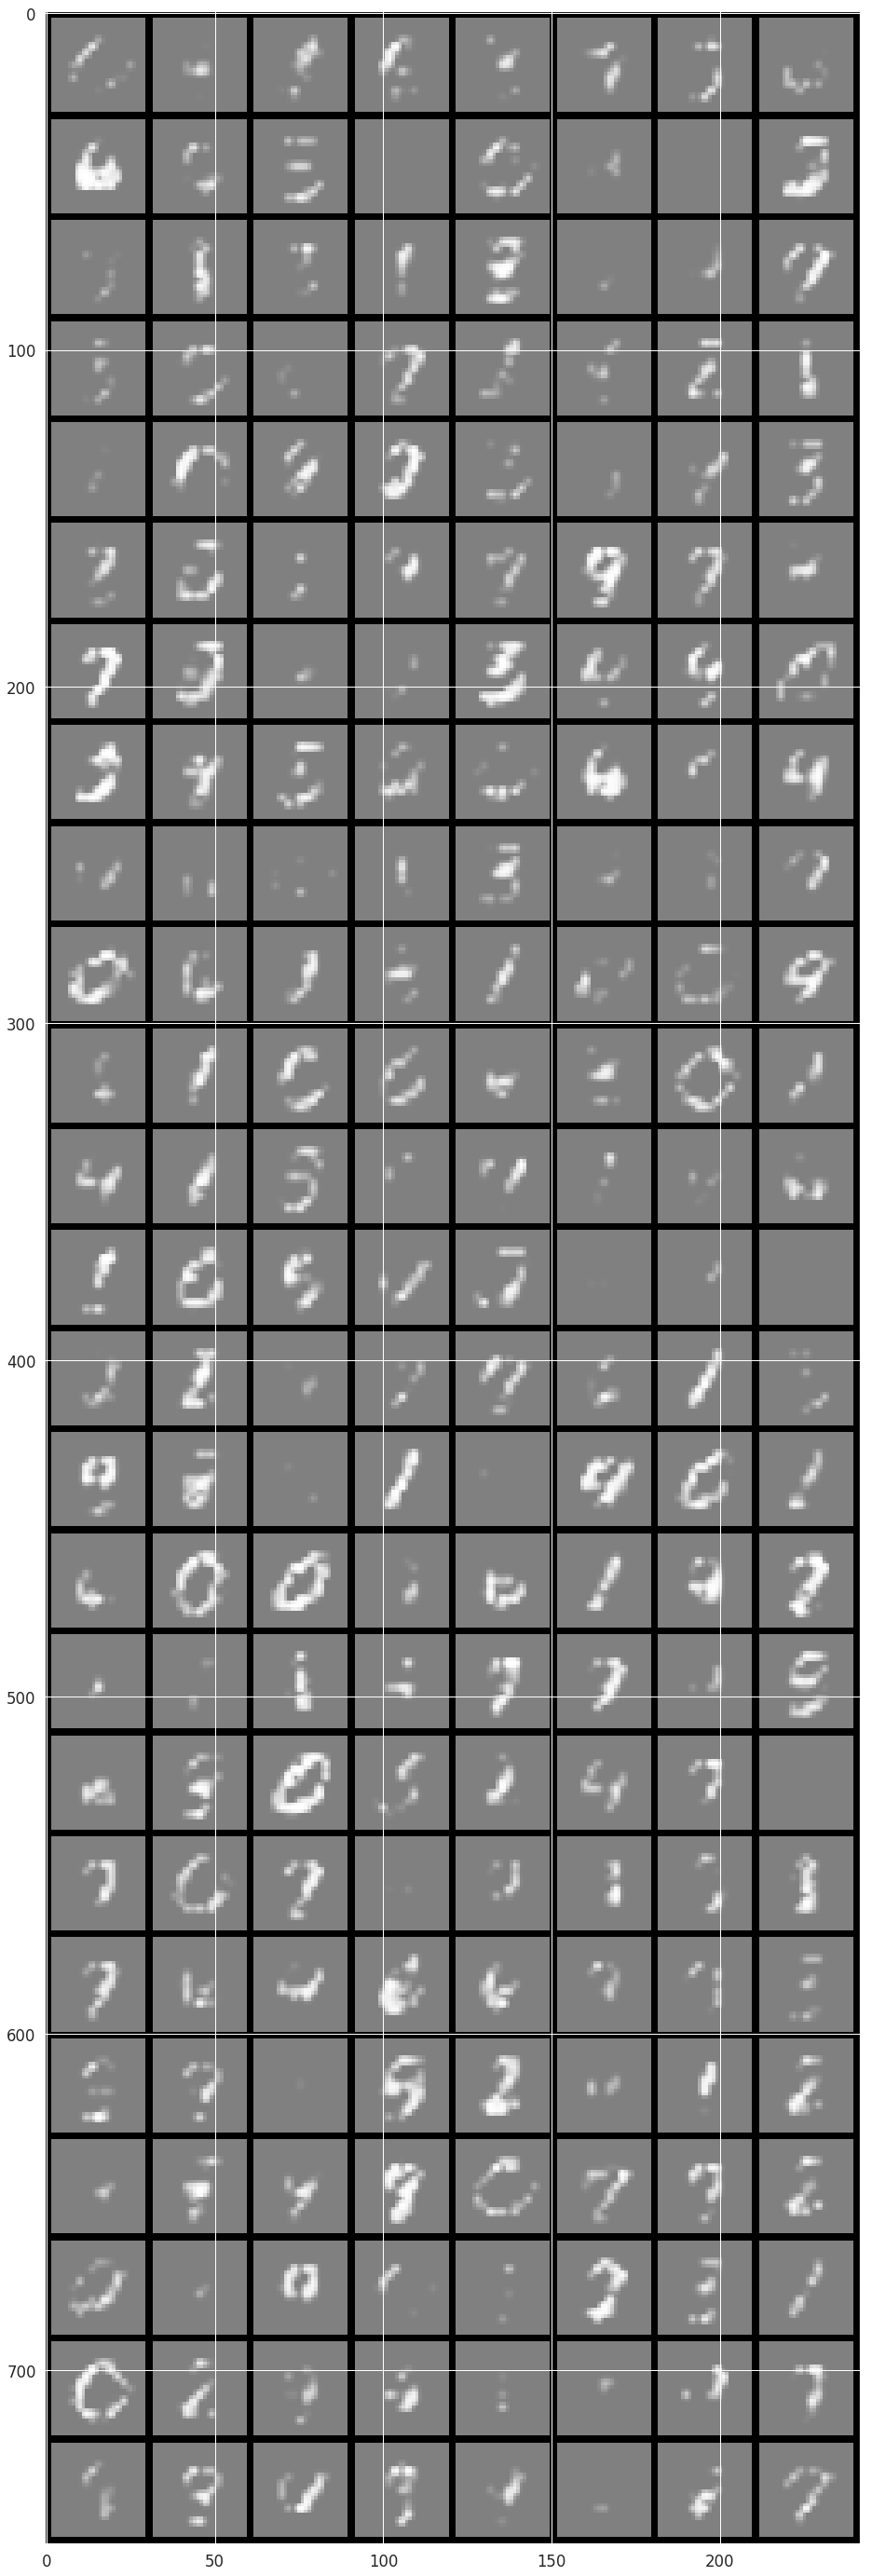

In [20]:
def show_images(images):
    plt.figure(figsize=(50, 50))
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

#dataiter = iter(trainloader)
#images, labels = dataiter.next()
#show_images(images)


with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        z, s, mu = vae_encoder(images)
        recon_image = vae_decoder(z)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            
            show_images(recon_image_.cpu())
            break
            

# Aside: umap
Newest nonlinear dimention reduction tool published (late 2018)
Can also use clustering on the embeddings

In [3]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()

embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



(1797, 2)


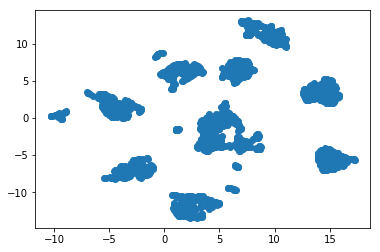

In [6]:
print(np.shape(embedding))
plt.scatter(embedding[:,0],embedding[:,1])

# Back to autoencoder with conv layers

So convolutional layers don't do so well...
what about linear layers

In [0]:

      
class VAE_encoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_encoder, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Linear(28*28,400),
                        #nn.BatchNorm1d(num_features=1),
                        nn.ReLU(inplace=True),
                        nn.Linear(400,18))#,
                        #nn.BatchNorm1d(num_features=1))
        
        self.fc2m = nn.Linear(18, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(18, latent_variable_dim) # use for standard deviation

    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        #pdb.set_trace()
        x = input.view(-1, 28*28)
        x = self.encoder(x)
        x = torch.sigmoid(x)

        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        #import pdb; pdb.set_trace()
        
        return z, m, log_s
    
class VAE_decoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_decoder, self).__init__()
        
        self.decoder = nn.Sequential(
                        nn.Linear(18,400),
                        #nn.BatchNorm1d(num_features=1),
                        nn.ReLU(inplace=True),
                        nn.Linear(400,28*28))#,
                        #nn.BatchNorm1d(num_features=1))
        
        self.f1 = nn.Linear(latent_variable_dim,18)
        
        
    def forward(self, z):
        #x = torch.relu(self.fc1(z))
        #x = torch.sigmoid(self.fc2(x))
        #pdb.set_trace()
        
        z = torch.relu(self.f1(z))
        z = self.decoder(z)
        #z = torch.relu(self.f2(z))
        x = z.view(z.size(0),1,28,28)
        #pdb.set_trace()
        #x = self.decoder(x)
        #pdb.set_trace()
        x = torch.sigmoid(x)
        
        return x
        
        
    

In [0]:

def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image.view(-1,28*28), input_image.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return CE + KLD

tensor(35427.8633, device='cuda:0', grad_fn=<AddBackward0>) tensor(33043.1445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27176.8066, device='cuda:0', grad_fn=<AddBackward0>) tensor(26384.1270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24908.1523, device='cuda:0', grad_fn=<AddBackward0>) tensor(24155.3301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23852.3926, device='cuda:0', grad_fn=<AddBackward0>) tensor(22502.6152, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22610.6641, device='cuda:0', grad_fn=<AddBackward0>) tensor(22581.0840, device='cuda:0', grad_fn=<AddBackward0>)


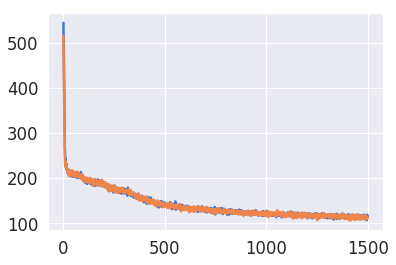

In [26]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
'''
'''
vae_encoder = VAE_encoder(10).to(device)
vae_decoder = VAE_decoder(10).to(device)

optimizer = optim.Adam(list(vae_encoder.parameters()) +list(vae_decoder.parameters()), lr = 0.003)
train_loss = []
val_loss = []
'''
'''
for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        optimizer.zero_grad()
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        larr = loss(images, recon_image, mu, s)
        
        larr.backward()
        train_loss.append(larr.item() / len(images))
        optimizer.step()
        
        i, data = next(iter(testloader))
        images = i
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        
        larr2 = loss(images, recon_image, mu, s)
        val_loss.append(larr2.item() / len(images))
        
    print(larr,larr2)
    
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

Both training and validation loss is lower than the convolutional layer case

torch.Size([200, 10]) torch.Size([200])


(<Figure size 576x576 with 1 Axes>,
 [Text(-3.2847247, -4.684992, '0'),
  Text(-9.323385, 10.862258, '1'),
  Text(-5.5621896, 3.9615064, '2'),
  Text(-1.7891821, 10.166252, '3'),
  Text(3.1691513, -4.4818764, '4'),
  Text(-0.21275902, -10.426226, '5'),
  Text(-7.1389346, -8.362667, '6'),
  Text(10.348596, -1.0002546, '7'),
  Text(0.19265158, 2.0044627, '8'),
  Text(6.2887163, -0.90612936, '9')])

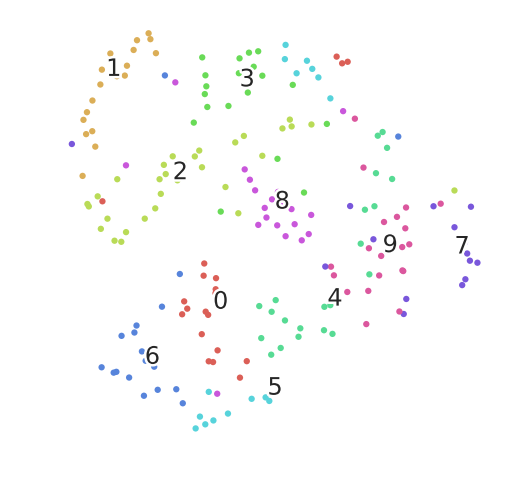

In [27]:
with torch.no_grad():
    for i, data in enumerate(viz_loader, 0):
        images, labels = data
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        print(mu.shape, labels.shape)
        pca = PCA(n_components=4)
        pca_result = pca.fit_transform(mu.cpu().numpy())
        fashion_tsne = TSNE().fit_transform(mu.cpu().numpy())
        
        break
pretty_scatter(fashion_tsne,labels.numpy())
#pretty_scatter(pca_result,labels.numpy())

Also performs much better, more cluster structure here.

Below is what PCA shows. harder to tell apart clusters

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.6907376, -1.1022638, '0'),
  Text(0.26089126, 0.943352, '1'),
  Text(0.80018955, -0.4562479, '2'),
  Text(1.5518162, -0.35449862, '3'),
  Text(-1.4701872, 0.16420716, '4'),
  Text(0.13051808, -0.7533452, '5'),
  Text(-0.91043985, -1.292306, '6'),
  Text(0.10517176, 1.4183096, '7'),
  Text(0.34986895, 0.70676124, '8'),
  Text(-0.5243187, 1.237438, '9')])

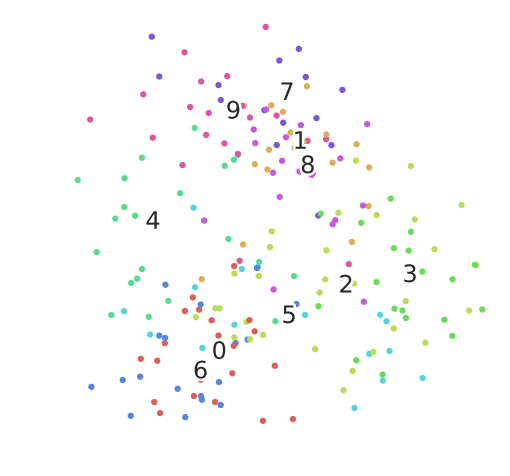

In [28]:
pretty_scatter(pca_result,labels.numpy())

Lets check out some reconstructions

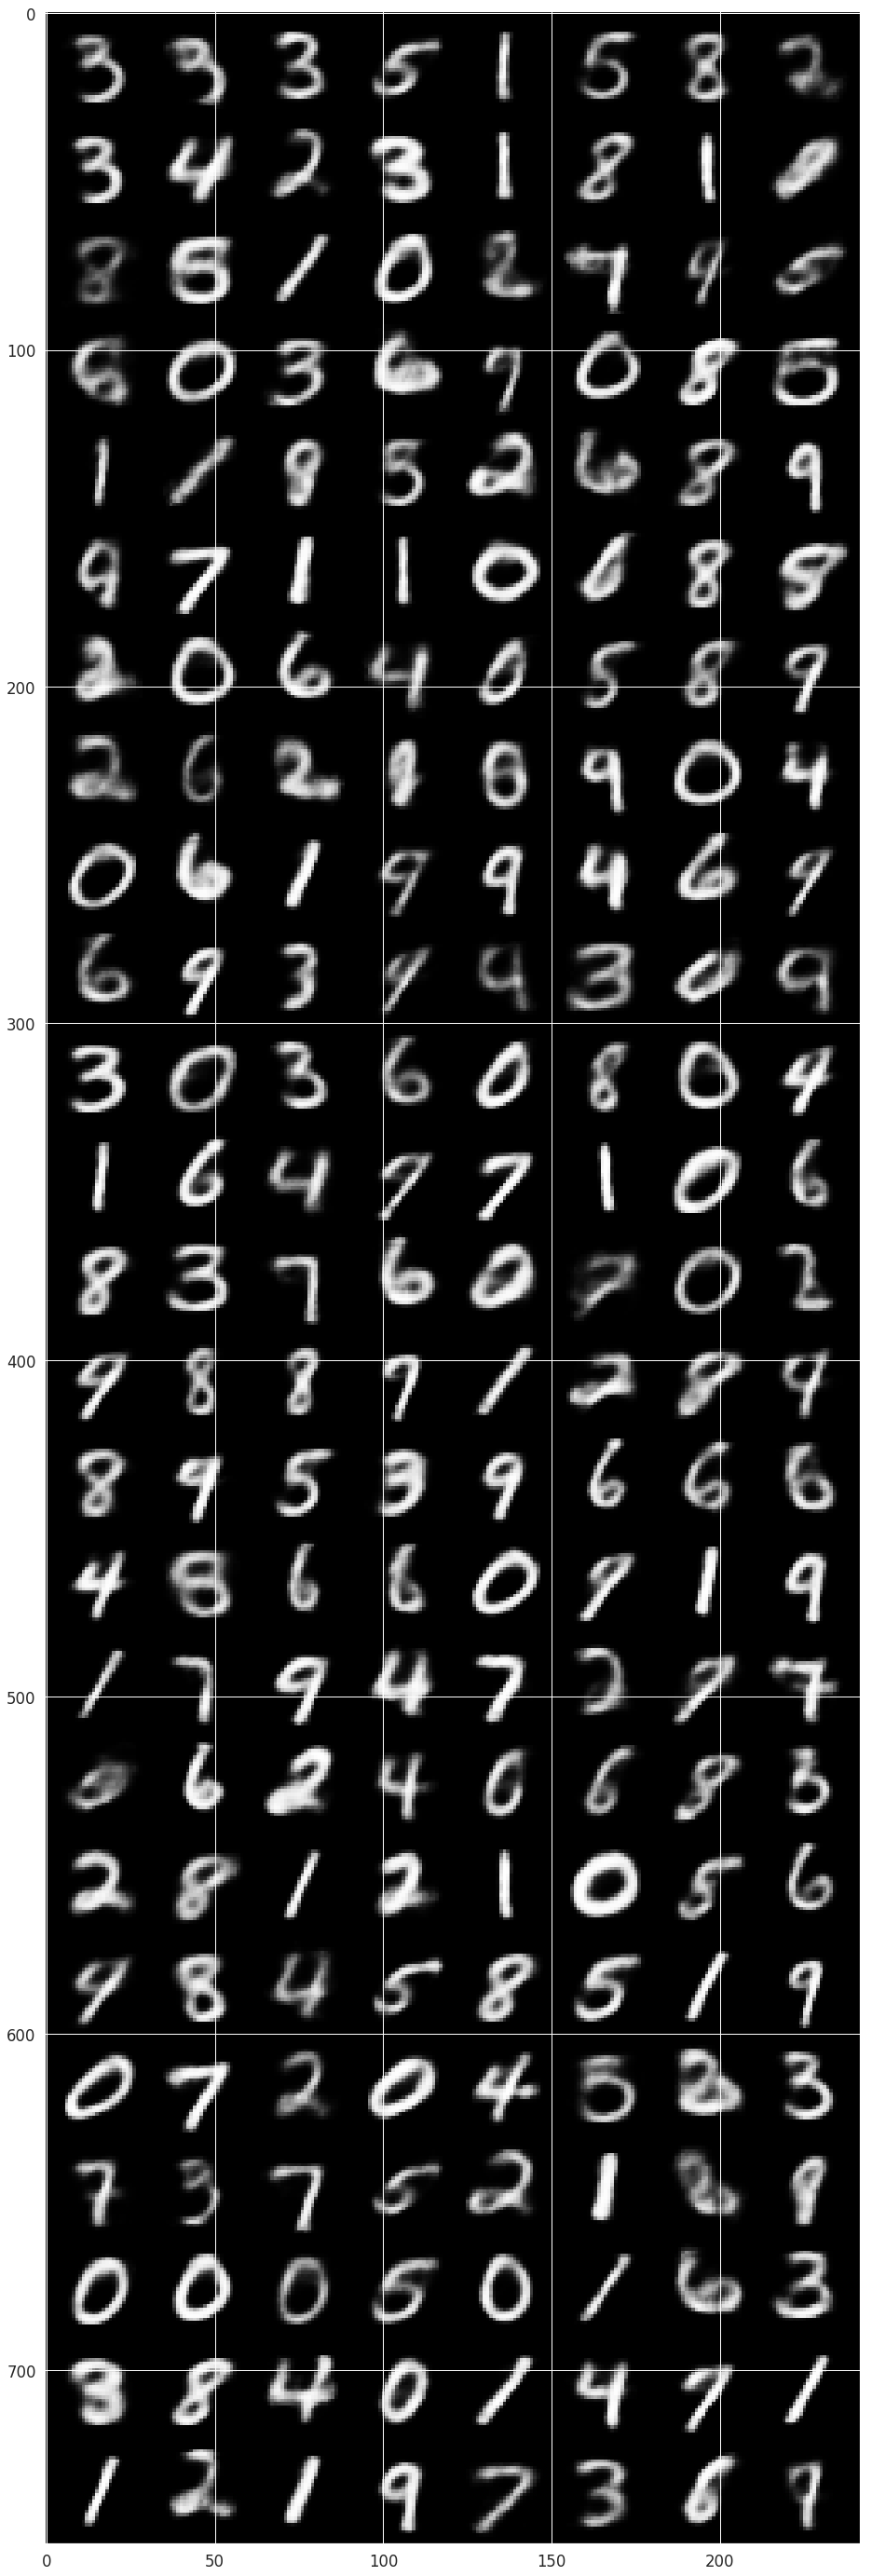

In [30]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        z, s, mu = vae_encoder(images)
        recon_image = vae_decoder(z)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            
            show_images(recon_image_.cpu())
            break

#Test on the real dataset

In [29]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My\ Drive/Colab\ Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


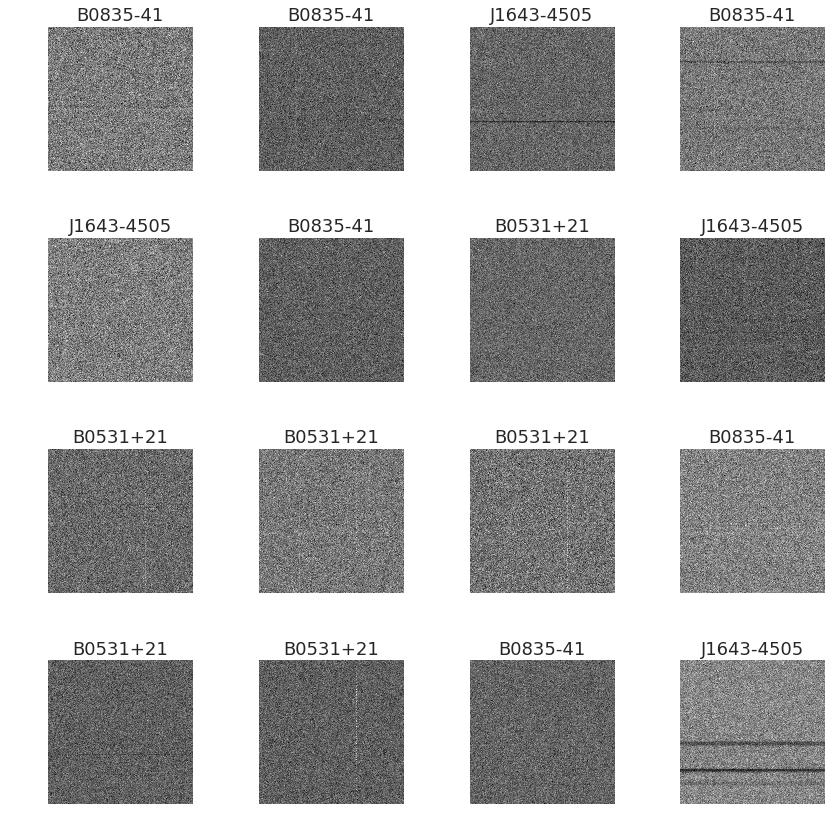

In [32]:
BATCH_SIZE = 300
IMG_SIZE = 336

import torch.utils.data as data

path = Path('pulses')
classes = ['B0531+21','B0835-41','J1643-4505']

transf = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.Grayscale(),
                            transforms.CenterCrop(IMG_SIZE),
                            transforms.ToTensor(), transforms.Normalize(mean=(0.5,),std=(0.117,))])


allData = torchvision.datasets.ImageFolder(root=path,transform=transf)


np.random.seed(42)

trainSize = int(len(allData)*0.8//10)
valSize = int(len(allData) - trainSize)
trainSet, valSet = data.random_split(allData,[trainSize,valSize])



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
myDataBunch = DataBunch.create(train_ds=trainSet,valid_ds=valSet,bs=BATCH_SIZE,device=device)



trainLoader = data.DataLoader(trainSet,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
valLoader = data.DataLoader(valSet,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
visLoader = data.DataLoader(trainSet,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
nBatches = trainSize//BATCH_SIZE#+1




dataFAI = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=[None,None], size=IMG_SIZE, bs = BATCH_SIZE, num_workers=4).normalize(imagenet_stats)
dataFAI.show_batch(rows=4, figsize=(12,12))

In [0]:
#changed 28*28=784 view
def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image.view(-1,336*336), input_image.view(-1, 336*336), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return CE + KLD

Run this cell if you want convolutional layers in the autoencoder

In [0]:

      
class VAE_encoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_encoder, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(1,1,kernel_size=(3,3),stride=(2,2),padding=(1,1),bias=False),
                        nn.BatchNorm2d(num_features=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=(3,3),stride=(2,2)))
        self.f1 = nn.Linear(6889, 225)
        self.fc2m = nn.Linear(225, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(225, latent_variable_dim) # use for standard deviation

    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        #pdb.set_trace()
        x = input.view(-1, 1,336,336)
        x = self.encoder(x)
        
        #print(x.shape)
        x = x.view(x.size(0),-1)
        x = torch.relu(self.f1(x))
        #print(x.shape)
        
        #torch.relu(self.fc1(x))
        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        #import pdb; pdb.set_trace()
        
        return z, m, log_s
    
class VAE_decoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_decoder, self).__init__()
        
        self.f1 = nn.Linear(latent_variable_dim,225)
        self.f2 = nn.Linear(225,6889)
        self.decoder = nn.Sequential(
                        nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False),
                        nn.BatchNorm2d(num_features=1),nn.ReLU(inplace=True),
                        nn.Upsample(size=(336, 336), mode='bilinear',align_corners=False))
        self.fc1 = nn.Linear(latent_variable_dim, 400)
        self.fc2 = nn.Linear(400, 784)
        
    def forward(self, z):
        #x = torch.relu(self.fc1(z))
        #x = torch.sigmoid(self.fc2(x))
        #pdb.set_trace()
        z = torch.relu(self.f1(z))
        z = torch.relu(self.f2(z))
        x = z.view(z.size(0),1,83,83)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        
        return x
        
        
    

run this cell if you only want linear layers

In [0]:

      
class VAE_encoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_encoder, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Linear(336*336,336),
                        #nn.BatchNorm1d(num_features=1),
                        nn.ReLU(inplace=True),
                        nn.Linear(336,18))#,
                        #nn.BatchNorm1d(num_features=1))
        
        self.fc2m = nn.Linear(18, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(18, latent_variable_dim) # use for standard deviation

    def reparameterize(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        #pdb.set_trace()
        x = input.view(-1, 336*336)
        x = self.encoder(x)
        x = torch.sigmoid(x)
        
        #print(x.shape)
        #x = x.view(x.size(0),-1)
        #x = torch.relu(self.f1(x))
        #print(x.shape)
        
        #torch.relu(self.fc1(x))
        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        #import pdb; pdb.set_trace()
        
        return z, m, log_s
    
class VAE_decoder(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE_decoder, self).__init__()
        
        self.decoder = nn.Sequential(
                        nn.Linear(18,336),
                        #nn.BatchNorm1d(num_features=1),
                        nn.ReLU(inplace=True),
                        nn.Linear(336,336*336))#,
                        #nn.BatchNorm1d(num_features=1))
        
        self.f1 = nn.Linear(latent_variable_dim,18)
        
        
    def forward(self, z):
        #x = torch.relu(self.fc1(z))
        #x = torch.sigmoid(self.fc2(x))
        #pdb.set_trace()
        
        z = torch.relu(self.f1(z))
        z = self.decoder(z)
        #z = torch.relu(self.f2(z))
        x = z.view(z.size(0),1,336,336)
        #pdb.set_trace()
        #x = self.decoder(x)
        #pdb.set_trace()
        x = torch.sigmoid(x)
        
        return x
        
        
    

tensor(13595682., device='cuda:0', grad_fn=<AddBackward0>) tensor(14591301., device='cuda:0', grad_fn=<AddBackward0>)
tensor(13229133., device='cuda:0', grad_fn=<AddBackward0>) tensor(14206626., device='cuda:0', grad_fn=<AddBackward0>)
tensor(12874163., device='cuda:0', grad_fn=<AddBackward0>) tensor(13830076., device='cuda:0', grad_fn=<AddBackward0>)
tensor(12496982., device='cuda:0', grad_fn=<AddBackward0>) tensor(13342967., device='cuda:0', grad_fn=<AddBackward0>)
tensor(12084282., device='cuda:0', grad_fn=<AddBackward0>) tensor(12913775., device='cuda:0', grad_fn=<AddBackward0>)


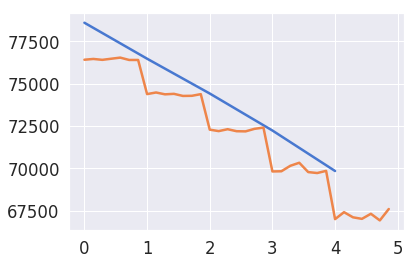

In [37]:

'''
'''
vae_encoder = VAE_encoder(3).to(device)
vae_decoder = VAE_decoder(3).to(device)

optimizer = optim.Adam(list(vae_encoder.parameters()) +list(vae_decoder.parameters()), lr = 0.0005)
train_loss = []
val_loss = []
'''
'''
for epoch in range(5):
    for i, data in enumerate(trainLoader, 0):
        images, labels = data
        images = images.to(device)
        optimizer.zero_grad()
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        larr = loss(images, recon_image, mu, s)
        
        larr.backward()
        train_loss.append(larr.item() / len(images))
        optimizer.step()
        
    for i, data in enumerate(valLoader):
        #images = i
        #images = images.to(device)
        images, labels = data
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        #print(z.shape)
        recon_image = vae_decoder(z)
        #pdb.set_trace()
        
        larr2 = loss(images, recon_image, mu, s)
        val_loss.append(larr2.item() / len(images))
        
    print(larr,larr2)

mult = len(train_loss)/len(val_loss)
plt.plot(np.arange(len(train_loss)),train_loss)
plt.plot(np.arange(len(val_loss))*mult,val_loss)
plt.show()

Training for more epochs didn't seem to help.

torch.Size([173, 3]) torch.Size([173])


(<Figure size 576x576 with 1 Axes>,
 [Text(-1.696448, -0.6522398, '0'),
  Text(-0.79530615, -1.9652061, '1'),
  Text(-0.16907513, 1.2397943, '2')])

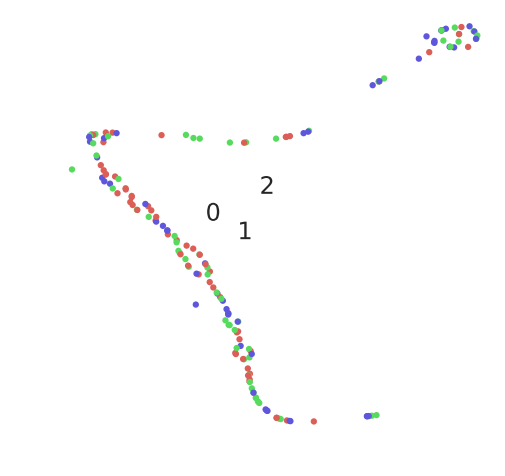

In [39]:
with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        images, labels = data
        images = images.to(device)
        z, mu, s = vae_encoder(images)
        print(mu.shape, labels.shape)
        pca = PCA(n_components=4)
        #pca_result = pca.fit_transform(mu.cpu().numpy())
        fashion_tsne = TSNE().fit_transform(mu.cpu().numpy())
        
        break
pretty_scatter(fashion_tsne,labels.numpy())
#pretty_scatter(pca_result,labels.numpy())

Session crashed :(

In [1]:


with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        images, labels = data
        images = images.to(device)
        z, s, mu = vae_encoder(images)
        recon_image = vae_decoder(z)
        recon_image_ = recon_image.view(-1, 1, 336, 336)
        
        plt.figure(figsize=(12, 12))
        plt.subplot(1,2,1)
        plt.imshow(images[8][0], cmap='gray')
        plt.grid(None) 
        plt.subplot(1,2,2)
        plt.imshow(recon_image[8][0], cmap='gray')
        plt.grid(None) 
        plt.show()
        break
            

NameError: ignored

In [0]:



with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        images, labels = data
        images = images.to(device)
        z, s, mu = vae_encoder(images)
        recon_image = vae_decoder(z)
        recon_image_ = recon_image.view(-1, 1, 336, 336)
        show_images(recon_image_.cpu())
        break
            